# Classical backtracking algorithm

In [ ]:
import numpy as np
from math import sqrt

def in_row(grid: np.ndarray, row: int, val: int) -> bool:
    """Check whether val is in the row of the grid."""
    grid_size = len(grid)
    for i in range(grid_size):
        if grid[row, i] == val:
            return True
    return False


def in_column(grid: np.ndarray, column: int, val: int) -> bool:
    """Check whether val is in the column of the grid."""
    grid_size = len(grid)
    for i in range(grid_size):
        if grid[i, column] == val:
            return True
    return False


def in_box(grid: np.ndarray, row: int, column: int, val: int) -> bool:
    """Check whether val is in the inner box of the grid."""
    grid_size = len(grid)
    box_size = round(sqrt(grid_size))

    # Calculate the upper-left corner of the inner box
    row_0 = (row // box_size) * box_size
    column_0 = (column // box_size) * box_size

    for r in range(box_size):
        for c in range(box_size):
            if grid[row_0 + r, column_0 + c] == val:
                return True
    return False


def is_distinct(grid: np.ndarray, row: int, column: int, val: int) -> bool:
    """Verify if the val in the given row/column is distinct."""
    return (
            not in_row(grid, row, val)
            and not in_column(grid, column, val)
            and not in_box(grid, row, column, val)
    )


def solve_sudoku_backtracking(grid: np.ndarray, solutions: [] = None):
    """Fill solutions with grids that satisfy Sudoku rules."""
    if solutions is None:
        solutions = []
    grid_size = len(grid[0])
    for r in range(grid_size):
        for c in range(grid_size):
            if grid[r, c] == -1:
                for val in range(grid_size):
                    if is_distinct(grid, r, c, val):
                        grid[r, c] = val
                        solve_sudoku_backtracking(grid, solutions)
                        grid[r, c] = -1
                return
    solutions.append(grid.copy())

## Run

In [ ]:
sudoku = np.array(
    [[-1, -1, -1, -1],
     [-1, -1, -1, -1],
     [-1, -1, -1, -1],
     [-1, -1, -1, -1]]
)

my_solutions = []
solve_sudoku_backtracking(sudoku, my_solutions)
print(sudoku)
print(f"Number of solutions: {len(my_solutions)}")
# for i in range(len(my_solutions)):
#     print(f"Solution #{i}")
#     print(my_solutions[i], "\n")

# Quantum algorithm

## Simulation setup

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.quantumregister import Qubit
from qiskit.visualization import plot_histogram, plot_bloch_multivector


def new_circuit(quantum_bits: int, classical_bits: int):
    """Create a new quantum circuit with given quantum volume."""
    qr = QuantumRegister(quantum_bits, "qreg")
    cr = ClassicalRegister(classical_bits, "creg")
    qc = QuantumCircuit(qr, cr)

    # set qubits to zero state
    for qubit in qr:
        qc.initialize('0', qubit)

    return qr, cr, qc


def simulate(qc: QuantumCircuit, shots: int = 1000, show_bloch: bool = False, title: str = None):
    """Draw the circuit, simulate a state vector and run simulations."""
    # simulate state vector
    statevector_backend = Aer.get_backend("statevector_simulator")
    statevector_job = execute(qc, backend=statevector_backend)
    statevector = statevector_job.result().get_statevector()

    # run simulations
    sim_backend = Aer.get_backend("qasm_simulator")
    sim_job = execute(qc, backend=sim_backend, shots=shots)
    counts = sim_job.result().get_counts()

    # display figures
    display(qc.draw(output="mpl"))
    if show_bloch:
        display(plot_bloch_multivector(statevector, figsize=(1, 1)))
    display(plot_histogram(counts, figsize=(6, 4), title=title))

## Superposition setup

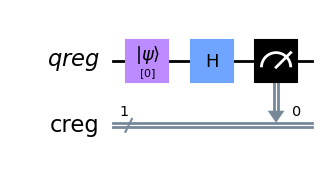

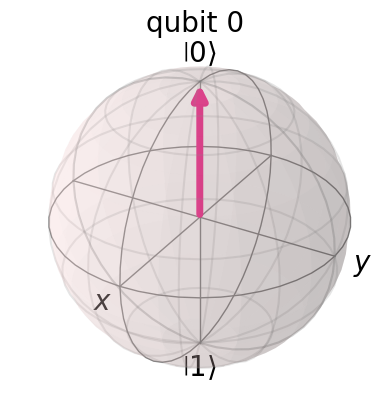

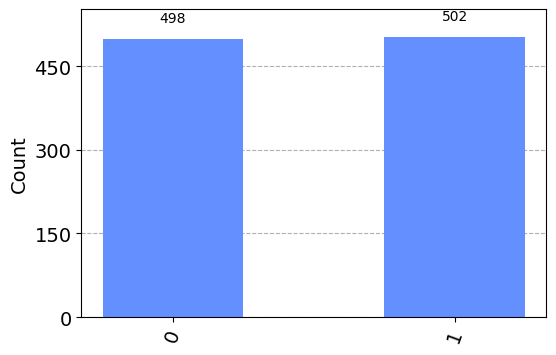

In [42]:
qr, cr, qc = new_circuit(1, 1)

qc.h(qr[0])
qc.measure(qr[0], cr[0])

simulate(qc)